# Quantum annealing for Gotham City problem using quantum simulator (julia)
The Quantum Annealing version implemented in this code is a quantum annealing simulator written in Julia where the inputs are the posible locations of the cell towers in Gothan city, these locations define the possible vertices of the graph, the graph and its possible edges will then define the specific Hamiltonian for the real problem, which in this case are map to the Hamiltonian of the form: $\hat{H(t)} = \Omega(t) \sum_{i \in V} \sigma_{i}^{x} - \delta(t) \sum_{i \in V} n_{i} +u \sum_{i,j \in E} n_{i}n_{j} $ (see the Instructions pdf file for more details) this Hamiltonian es used to define unitary evolution operators for small time steps,these operators are applied to the initial state to produce after some time the optimal state at time with the highest probability.
¶ 

### Loading libraries

In [1]:
# Libraries
import Pkg; 
Pkg.add("Yao")
Pkg.add("StatsBase")
Pkg.add("BitBasis")
Pkg.add("GRUtils")
#Pkg.add("PyPlot")

In [2]:
using Plots
using BitBasis
using StatsBase
using GraphRecipes
using GRUtils

#### Defining the functions get_edges to obtain the edges of the graph, $\delta$, $\Omega$, Hamitonian and the run_annealing functions. The cell tower coordinates inputs are also included here.

In [3]:
#!/usr/bin/env julia

using Yao
using Yao.ConstGate # needed for P1 = 0.5*(I - sigma_z) block

#=
H(t) = Ω(t) ∑_i σ_i^x - δ(t) ∑_i n_i + u ∑_ij n_i n_j
=#

const u = 1.35
const Ω_max = 1.89
const δ_0 = -1.0
const δ_max = 1.0

function get_edges(graph::Vector{NTuple{2, Float64}})
    Nv = size(graph)[1]
    edges = falses(Nv, Nv)
    for i in 1:(Nv-1)
        xi, yi = graph[i]
        for j in (i+1):Nv
            xj, yj = graph[j]

            dij = sqrt((xi - xj)^2. + (yi - yj)^2.)
            if dij <= 1.0
                edges[i,j] = true
            end
        end
    end
    return findall(edges)
end

function Ω(t::Float64)
    if 0 <= t <= 0.25
        return (Ω_max / 0.25) * t
    elseif 0.25 < t <= 0.69
        return Ω_max
    elseif 0.69 < t <= 1
        return - Ω_max * t / 0.31 + Ω_max * (1 + 0.69/0.31)
    end
end

function δ(t::Float64)
    slope = (δ_0 - δ_max)/(0.25 - 0.69)
    if 0 <= t <= 0.25
        return δ_0
    elseif 0.25 < t <= 0.69
        return t * slope + (δ_max - slope * 0.69)
    elseif 0.69 < t <= 1
        return δ_max
    end
end 

function hamiltonian(graph::Vector{NTuple{2, Float64}}, edges::Vector{CartesianIndex{2}}, t::Float64)
    # the UD-MIS Hamiltonian
    Nv = size(graph)[1] # number of vertices

    interaction_term = map(1:size(edges)[1]) do i
        l,m = edges[i][1], edges[i][2]
        repeat(Nv,u*P1,(l,m))
    end |> sum
    interaction_term - δ(t)*sum(map(i->put(Nv,i=>P1), 1:Nv)) + Ω(t)*sum(map(i->put(Nv,i=>X), 1:Nv))
end

function run_annealing(graph::Vector{NTuple{2, Float64}}, edges::Vector{CartesianIndex{2}}, dt::Float64)
    psi_t = zero_state(size(graph)[1])
    for t in 0:dt:1.0
        h = hamiltonian(graph, edges, t)
        psi_t = psi_t |> TimeEvolution(h, dt * 100)
    end
    return psi_t
end

#=
graph = [(1.19,  4.25), 
         (2.71,  3.48), 
         (1.19,  3.51), 
         (2.0,  3.38), 
         (1.12,  2.86), 
         (1.70,  2.42),
         (2.36,  2.54),
         (1.52,  1.48),
         (2.15,  1.54),
         (2.14,  1.87),
         (1.72,  0.86),
         (2.29,  0.87)
        ]
=#
graph = [((2.29,  0.87)),
        (1.72,  0.86),
        (2.14,  1.87),
        (2.15,  1.54),
        (1.52,  1.48),
        (2.36,  2.54),
        (1.70,  2.42),
        (1.12,  2.86),
        (2.0,  3.38),
        (1.19,  3.51),
        (2.71,  3.48),
        (1.19,  4.25)
]


edges = get_edges(graph)
dt = 0.001

psi = run_annealing(graph, edges, dt)
open("task2_data.dat","w") do io
    for sample in measure(psi; nshots=10_000)
        println(io, sample)
    end
end

samples = measure(psi; nshots=10000)
@show samples

samples = BitStr64{12}[110010100001 ₍₂₎, 110010100010 ₍₂₎, 110010000101 ₍₂₎, 110001000010 ₍₂₎, 110010100010 ₍₂₎, 100110000110 ₍₂₎, 110010100001 ₍₂₎, 110010100001 ₍₂₎, 110010110000 ₍₂₎, 110010100010 ₍₂₎, 110010000110 ₍₂₎, 110010110001 ₍₂₎, 110010110000 ₍₂₎, 110010100001 ₍₂₎, 110010100010 ₍₂₎, 110110000101 ₍₂₎, 110010100010 ₍₂₎, 110010110000 ₍₂₎, 110010000101 ₍₂₎, 110010100001 ₍₂₎, 110010000101 ₍₂₎, 110010101000 ₍₂₎, 110010101000 ₍₂₎, 110010100010 ₍₂₎, 110010110000 ₍₂₎, 110010100001 ₍₂₎, 110010100001 ₍₂₎, 110010101000 ₍₂₎, 110010100000 ₍₂₎, 100110000101 ₍₂₎, 100110010000 ₍₂₎, 110010100011 ₍₂₎, 110010000101 ₍₂₎, 110010000101 ₍₂₎, 110010100001 ₍₂₎, 110010110000 ₍₂₎, 110010100001 ₍₂₎, 110010101000 ₍₂₎, 100010100010 ₍₂₎, 110010100010 ₍₂₎, 110010110000 ₍₂₎, 110010000101 ₍₂₎, 110010000110 ₍₂₎, 110010100001 ₍₂₎, 110010000101 ₍₂₎, 110010100110 ₍₂₎, 100110000010 ₍₂₎, 110010000101 ₍₂₎, 110010100010 ₍₂₎, 100110000110 ₍₂₎, 110010000110 ₍₂₎, 110010000110 ₍₂₎, 110010101000 ₍₂₎, 110010100010 ₍₂₎, 11001

10000-element Vector{BitStr64{12}}:
 110010100001 ₍₂₎
 110010100010 ₍₂₎
 110010000101 ₍₂₎
 110001000010 ₍₂₎
 110010100010 ₍₂₎
 100110000110 ₍₂₎
 110010100001 ₍₂₎
 110010100001 ₍₂₎
 110010110000 ₍₂₎
 110010100010 ₍₂₎
 110010000110 ₍₂₎
 110010110001 ₍₂₎
 110010110000 ₍₂₎
                ⋮
 110010100001 ₍₂₎
 110010100010 ₍₂₎
 110010110000 ₍₂₎
 110010000110 ₍₂₎
 110010000101 ₍₂₎
 110010100001 ₍₂₎
 110010100001 ₍₂₎
 110010110000 ₍₂₎
 110010100010 ₍₂₎
 110010110001 ₍₂₎
 110010100001 ₍₂₎
 110010000101 ₍₂₎

#### Number of Edges shown here

In [4]:
@show edges

edges = CartesianIndex{2}[CartesianIndex(1, 2), CartesianIndex(1, 4), CartesianIndex(2, 4), CartesianIndex(3, 4), CartesianIndex(1, 5), CartesianIndex(2, 5), CartesianIndex(3, 5), CartesianIndex(4, 5), CartesianIndex(3, 6), CartesianIndex(3, 7), CartesianIndex(4, 7), CartesianIndex(5, 7), CartesianIndex(6, 7), CartesianIndex(7, 8), CartesianIndex(6, 9), CartesianIndex(8, 10), CartesianIndex(9, 10), CartesianIndex(9, 11), CartesianIndex(10, 12)]


19-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 2)
 CartesianIndex(1, 4)
 CartesianIndex(2, 4)
 CartesianIndex(3, 4)
 CartesianIndex(1, 5)
 CartesianIndex(2, 5)
 CartesianIndex(3, 5)
 CartesianIndex(4, 5)
 CartesianIndex(3, 6)
 CartesianIndex(3, 7)
 CartesianIndex(4, 7)
 CartesianIndex(5, 7)
 CartesianIndex(6, 7)
 CartesianIndex(7, 8)
 CartesianIndex(6, 9)
 CartesianIndex(8, 10)
 CartesianIndex(9, 10)
 CartesianIndex(9, 11)
 CartesianIndex(10, 12)

#### Plotting the distribution of states

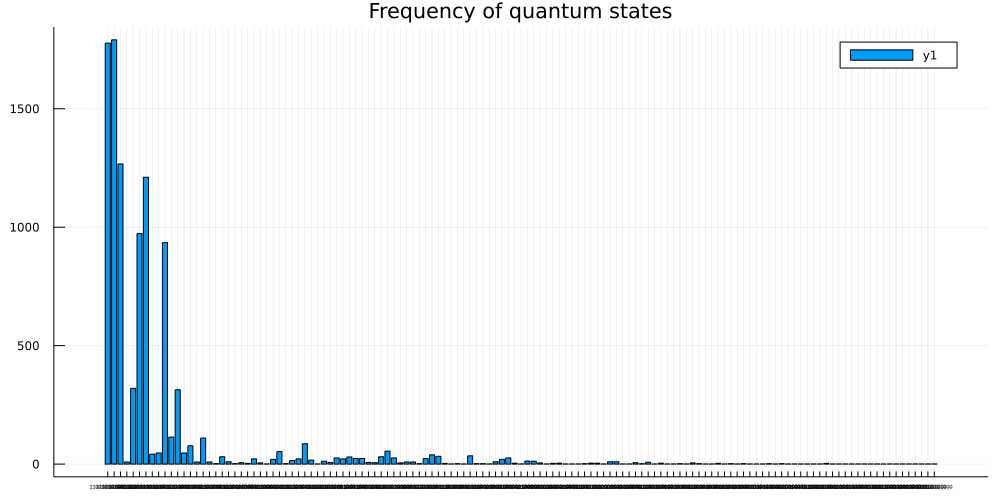

In [60]:

using Plots;
samples_int = [Int(b) for b in samples]
bins_int = unique(samples_int)
s = [string(each, base=2, pad=size(graph)[1]) for each in bins_int]

datamap = countmap(samples)
bins = unique(samples)
b_plot = Plots.bar((x -> datamap[x]).(bins),
    xticks=(1:size(s)[1],s),
    xtickfont = font(3, "Courier"),title="Frequency of quantum states")
Plots.plot!(size=(1000,500))

In [ ]:
# Saving the plot in a svg file
Plots.savefig(b_plot,""...\\CohortProject_2021\\Week2_Rydberg_Atoms\\Graphics\\Task3_Histogram.svg")

#### Plotting the MIS in blue and the remaining cell towers in red.

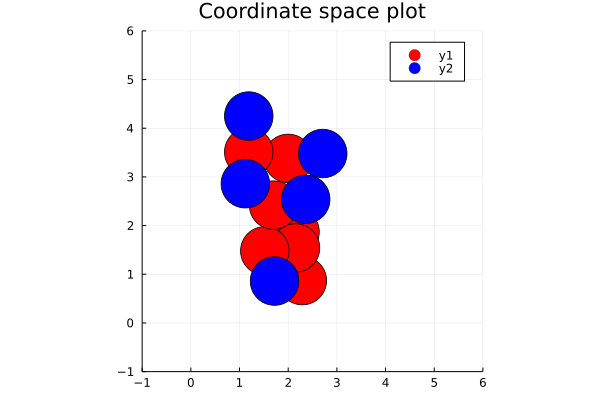

In [46]:
using Plots;

samples_int = [Int(b) for b in samples]
bins_int = unique(samples_int)
s = [string(each, base=2, pad=size(graph)[1]) for each in bins_int]

datamap = countmap(samples)
bins = unique(samples)
b_plot = Plots.bar((x -> datamap[x]).(bins),
    xticks=(1:size(s)[1],s),
    xtickfont = font(3, "Courier"))

#savefig(b_plot, "./Week2_Rydberg_Atoms/Graphics/histogram_solutions.svg")

# get the optimal string (simply as the max)
optimal_sol = findmax(datamap)

# plot graph solution
const G = zeros(size(graph)[1],size(graph)[1])

for i=1:size(edges)[1]
    G[edges[i][1],edges[i][2]] = 1
end

g_plot = graphplot(G,
          markersize = 0.3,
          fontsize = 10,
          linecolor = :darkgrey
          )

#savefig(g_plot, "./Week2_Rydberg_Atoms/Graphics/graph_plot.svg")

# plot graph in the coordinate space
bitstr_optim = optimal_sol[2]
Nv = size(graph)[1]

red_graph = [graph[i] for i in 1:bit_length(bitstr_optim) if bitstr_optim[i]==0]
blue_graph = [graph[i] for i in 1:bit_length(bitstr_optim) if bitstr_optim[i]==1]
#red_graph = [graph[i] for i in 1:bit_length(bitstr_optim) if bitstr_optim[Nv-i+1]==0]
#blue_graph = [graph[i] for i in 1:bit_length(bitstr_optim) if bitstr_optim[Nv-i+1]==1]

x = [x[1] for x in graph]
y = [x[2] for x in graph]


markerunit = 27 #17 #9 # empirically found
coord_plot = Plots.plot(x, y, seriestype = :scatter,
    title="Coordinate space plot",
    markersize=markerunit,
    xlims=(-1,4),
    ylims=(-1,4),
    aspect_ratio=:equal)

#savefig(coord_plot, "./Week2_Rydberg_Atoms/Graphics/coordinate_plot.svg")

x_red = [x[1] for x in red_graph]
y_red = [x[2] for x in red_graph]
x_blue = [x[1] for x in blue_graph]
y_blue = [x[2] for x in blue_graph]

coord_plot_2 = Plots.plot(x_red, y_red, seriestype = :scatter,
    title="Coordinate space plot",
    markersize=markerunit,
    markercolor = :red,
    xlims=(-1,4),
    ylims=(-1,4),
    aspect_ratio=:equal)

Plots.plot!(coord_plot_2, x_blue, y_blue, seriestype = :scatter,
    title="Coordinate space plot",
    markersize=markerunit,
    markercolor = :blue,
    xlims=(-1,6),
    ylims=(-1,6),
    aspect_ratio=:equal)

#savefig(coord_plot, "./Week2_Rydberg_Atoms/Graphics/coordinate_plot_solution.svg")
# Saving the plot in a svg file


In [51]:
Plots.savefig(coord_plot_2,"...\\CohortProject_2021\\Week2_Rydberg_Atoms\\Graphics\\Task3_coordinate_plot_solution.svg")

### Task 3 Questions:

#### 1.   Explain  why  this  is  a  problem  that  can  be  easily  mapped  to  the  UD-MIS  problem. A  few  sentences  is  all  that  is  needed.
This problem can be mapped to a UD-MIS problem by taking the cell phone towers as nodes $V$ of the graph $G(V,E)$ and edges $E$, the number of cell towers are $N = |V |$, and $S = (n1, · · · , nN )$ be an $N$ -bit string (i.e. $ni ∈ 0, 1$), $n_{i}=1$ can be interpreted as having a cell tower in place $n_{i}=1$ or not having a cell tower: $n_{i}=0$ with Hamming weight $S= \sum_{i=1}^{N}$.   The  MIS  problem  is  deﬁned  as  ﬁnding $Max_{S} S$



#### 2.   Solve  Gotham  City’s  problem.   Using  the  methods  provided  in  Tasks  1  and  2  Are  there multiple   solutions?
There are 2 solutions with same energy level but the most probable solution in the quantum case (|110010100010>), with the maximum independent set in blue in the graph. In he classical case we have also 2 degenerate solutions, with energy =-5.

#### 3.   Should   Bruce   pay   for   a   few   more   cell   phone   towers   to   make   sure   that   more   of Gotham   City  has   cell   phone  service?
Since the one of the conditions for solving the problem were that the tower signals should not overlap, then yes, Bruce should pay for a few towers more if he wants to make sure more of Gotham city has cell coverage. If he takes out the ovelapping restriction then he may not need extra cell phone towers.